In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# Variational Autoencoder (VAE) architecture for Multivariate Time Series

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers=1):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # LSTM output, get the hidden state
        h_n = h_n[-1]  # Take the hidden state of the last layer (LSTM)
        
        # Latent space parameters
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    def forward(self, z, seq_len):
        # Repeat z to match the sequence length
        z_repeated = z.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_out, _ = self.lstm(z_repeated)
        recon = self.fc_out(lstm_out)
        
        return recon


class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size, num_layers=1):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size, num_layers)
        self.decoder = Decoder(latent_size, hidden_size, output_size, num_layers)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)    # Sample from a standard normal distribution
        z = mu + eps * std             # Reparameterization trick
        return z
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        print(mu.shape)
        z = self.reparameterize(mu, logvar)
        print(z.shape)
        recon = self.decoder(z, seq_len=x.size(1))  # seq_len = sequence length of input
        return recon, mu, logvar

####################### HERE ##################################
# Loss Function: VAE loss (Reconstruction + KL divergence)
def vae_loss(y,beta, x, mu, logvar):
    # Reconstruction loss (MSE for time series)
    beta_tmp = beta.reshape(input_size,input_size)
    recon_loss = nn.MSELoss()(y, torch.matmul(x,beta_tmp))
    
    # KL Divergence: KLD = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kld_loss


# Sample usage
if __name__ == "__main__":
    # Hyperparameters
    input_size = 3      # Number of variables in the multivariate time series
    hidden_size = 64    # LSTM hidden layer size
    latent_size = 16    # Size of latent space
    output_size = input_size*input_size
    num_layers = 2      # Number of LSTM layers
    seq_len = 30        # Length of time series sequences
    batch_size = 32     # Batch size
    
    # Model initialization
    model = VAE(input_size, hidden_size, latent_size, output_size, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Example input: batch of multivariate time series
    x = torch.randn(batch_size, seq_len, input_size)  # (batch_size, seq_len, input_size)
    y = torch.randn(batch_size, seq_len, input_size)  # (batch_size, seq_len, input_size)
    
    # Training loop (simplified)
    model.train()
    for epoch in range(100):  # Example: 100 epochs
        optimizer.zero_grad()
        beta, mu, logvar = model(x)
        print(beta.shape)
        loss = vae_loss(y, beta, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')


torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 30, 9])


RuntimeError: shape '[3, 3]' is invalid for input of size 8640

In [6]:
import torch 

u = torch.tensor([1,2,3,4])

In [7]:
u.reshape(2,2)

tensor([[1, 2],
        [3, 4]])

In [21]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 
import matplotlib.pyplot as plt

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

######## Store Nan indices 

nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    

        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

############################


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})
dic_forced_response_ssp585_tmp = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    dic_forced_response_ssp585_tmp[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = y_tmp/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += y_tmp/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):       
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_14438/1854325067.py:102: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_14438/1854325067.py:104: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [22]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train[m][i] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)

In [23]:
count_runs = 0
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        count_runs += 1

In [24]:
# Data preprocessing
x_train_merged = torch.zeros((count_runs,time_period,lon_size*lat_size))
y_train_merged = torch.zeros((count_runs,time_period,lon_size*lat_size))

count = 0
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train_merged[count,:,:] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train_merged[count,:,:] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)
        count += 1

In [31]:
# Hyperparameters
input_size = lon_size*lat_size      # Number of variables in the multivariate time series
hidden_size = 64    # LSTM hidden layer size
latent_size = 16    # Size of latent space
num_layers = 2     # Number of LSTM layers
seq_len = time_period        # Length of time series sequences
batch_size = 300     # Batch size
    
# Model initialization
model = VAE(input_size, hidden_size, latent_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
# Example input: batch of multivariate time series
x = x_train_merged[:batch_size,:,:]
print(x)
y = y_train_merged[:batch_size,:,:]
    
# Training loop (simplified)
model.train()
for epoch in range(1000):  # Example: 100 epochs
    optimizer.zero_grad()
    recon_x, mu, logvar = model(x)
    loss = vae_loss(recon_x[:,:,notnan_idx], y[:,:,notnan_idx], mu, logvar)
    loss.backward()
    optimizer.step()
        
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

tensor([[[ 0.0000,  0.0000,  0.0000,  ..., -0.0409, -0.0408, -0.0384],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0199, -0.0190, -0.0176],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0359, -0.0353, -0.0337],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0128,  0.0119,  0.0118],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0138,  0.0130,  0.0125],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0302,  0.0309,  0.0329]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0186, -0.0170, -0.0144],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0136,  0.0143,  0.0151],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0033, -0.0048, -0.0061],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0187,  0.0179,  0.0169],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0162,  0.0158,  0.0153],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0260,  0.0258,  0.0252]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.0445, -0.0438, -0.0428],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [55]:
y_pred, mu, logvar = model(x_train_merged[batch_size:,:,:])

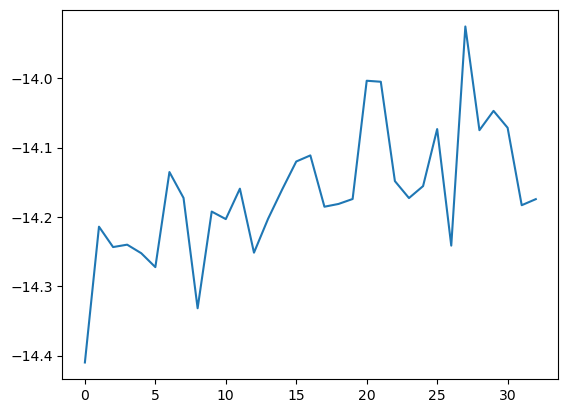

In [56]:
plt.figure()
plt.plot(y_train_merged[1,:,500].detach().numpy())
plt.show()

In [45]:
torch.nansum((y_train_merged[batch_size:,:,:] - y_pred)**2)

tensor(186172.3125, grad_fn=<NansumBackward0>)